In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import dill
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data
from mypkg.visualization import LivePlot

import csng
from csng.GAN import GAN
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.data import MixedBatchLoader
from csng.readins import MultiReadIn, ConvReadIn

from encoder import get_encoder
from data_utils import (
    get_mouse_v1_data,
    PerSampleStoredDataset,
    append_syn_dataloaders,
    append_data_aug_dataloaders,
    RespGaussianNoise,
)
from cnn_decoder_utils import get_all_data


lt.monkey_patch()
DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "mouse_v1": None,
        "syn_dataset_config": None,
        "data_augmentation": None,
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
    # "wandb": None,
    "wandb": {
        "project": "CSNG",
        "group": "sensorium_2022",
    },
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 16,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4480 samples
Validation dataset:	 528 samples
Test dataset:		 105 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


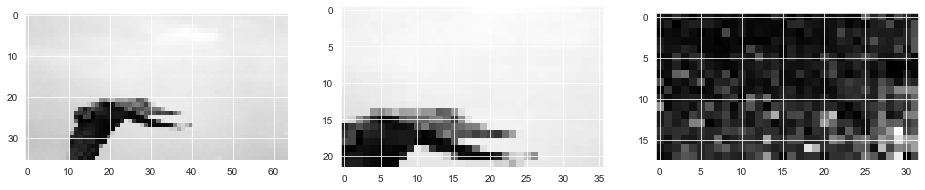

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 7,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None, # the same data key as the original (real) data
    "dir_name": "synthetic_data_mouse_v1_encoder_new_stimuli",
    "device": config["device"],
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
syn_sample_data_key = dataloaders["mouse_v1"]["train"].data_keys[-1]
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[syn_sample_data_key].shape}"
    f"\n  min={neuron_coords[syn_sample_data_key].min():.3f}  max={neuron_coords[syn_sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[syn_sample_data_key].mean():.3f}  std={neuron_coords[syn_sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[syn_sample_data_key]
H, W = syn_stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = syn_resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

## Encoder

In [ ]:
encoder = get_encoder(
    device=config["device"],
    eval_mode=True,
    # use_shifter=False,
    # ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_no_shifter.pth"),
)

## Decoder

In [8]:
def val(model, dataloader, loss_fn, only_data_keys=None):
    model.eval()
    val_losses = {"total": 0}
    n_samples = 0
    denom_data_keys = {}
    with torch.no_grad():
        for b in dataloader:
            ### combine from all data keys
            for data_key, stim, resp, neuron_coords, pupil_center in b:
                if only_data_keys is not None and data_key not in only_data_keys:
                    continue
                stim_pred = model(
                    resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )
                loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
                val_losses["total"] += loss
                val_losses[data_key] = loss if data_key not in val_losses else val_losses[data_key] + loss
                denom_data_keys[data_key] = denom_data_keys[data_key] + resp.shape[0] if data_key in denom_data_keys else resp.shape[0]
                n_samples += resp.shape[0]

    val_losses["total"] /= n_samples
    for k in denom_data_keys:
        val_losses[k] /= denom_data_keys[k]
    return val_losses

In [9]:
def train(model, dataloader, loss_fn, config, history, live_plot, epoch, log_freq=100):
    model.train()

    ### run
    for batch_idx, b in enumerate(dataloader):
        D_loss, G_loss = 0, 0

        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            ### get discriminator loss
            real_stim_pred = model.core.D(crop(stim, config["crop_win"]))
            # add noise to labels (uniform distribution between 0.95 and 1)
            noisy_real_stim_labels = (
                1. - config["decoder"]["D_real_stim_labels_noise"] 
                + torch.rand_like(real_stim_pred) * config["decoder"]["D_real_stim_labels_noise"]
            )
            real_stim_loss = torch.mean((real_stim_pred - noisy_real_stim_labels)**2) / 2.

            stim_pred = model(
                resp,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center
            )
            fake_stim_pred = model.core.D(crop(stim_pred.detach(), config["crop_win"]))
            # add noise to labels (uniform distribution between 0 and noise level)
            noisy_fake_stim_labels = torch.rand_like(fake_stim_pred) * config["decoder"]["D_fake_stim_labels_noise"]
            fake_stim_loss = torch.mean((fake_stim_pred - noisy_fake_stim_labels)**2) / 2.
            # total
            D_loss += config["decoder"]["D_real_loss_mul"] * real_stim_loss
            D_loss += config["decoder"]["D_fake_loss_mul"] * fake_stim_loss


            ### get generator loss
            stim_pred = crop(model(
                resp,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center
            ), config["crop_win"])
            fake_stim_pred = model.core.D(stim_pred)

            G_loss_adv = torch.mean((fake_stim_pred - 1.)**2) / 2
            G_loss_stim = loss_fn(stim_pred, stim) / 2
            # total
            G_loss += config["decoder"]["G_adv_loss_mul"] * G_loss_adv
            G_loss += config["decoder"]["G_stim_loss_mul"] * G_loss_stim


        ##### update generator [START] #####
        model.core.G_optim.zero_grad()
        G_loss /= len(b)

        # regularization
        if config["decoder"]["G_reg"]["l2"] > 0:
            l2_reg = sum(p.pow(2).sum() for n,p in model.core.G.named_parameters() \
                if p.requires_grad and "weight" in n)
            G_loss += config["decoder"]["G_reg"]["l2"] * l2_reg
        if config["decoder"]["G_reg"]["l1"] > 0:
            l1_reg = sum(p.abs().sum() for n,p in model.core.G.named_parameters() \
                if p.requires_grad and "weight" in n)
            G_loss += config["decoder"]["G_reg"]["l1"] * l1_reg
        G_loss.backward()

        # clip gradients
        for p in model.core.G.parameters():
            p.grad.data.clamp_(-1., 1.)
        
        # log
        history["G_mean_abs_grad_first_layer"].append(torch.mean(torch.abs(model.core.G.layers[0].weight.grad)).item())
        history["G_mean_abs_grad_last_layer"].append(torch.mean(torch.abs(model.core.G.layers[-2].weight.grad)).item())

        # step
        model.core.G_optim.step()
        ##### update generator [END] #####


        ##### update discriminator [START] #####
        model.core.D_optim.zero_grad()
        D_loss /= len(b)

        # regularization
        if config["decoder"]["D_reg"]["l2"] > 0:
            l2_reg = sum(p.pow(2).sum() for n,p in model.core.D.named_parameters() \
                if p.requires_grad and "weight" in n)
            D_loss += config["decoder"]["D_reg"]["l2"] * l2_reg
        if config["decoder"]["D_reg"]["l1"] > 0:
            l1_reg = sum(p.abs().sum() for n,p in model.core.D.named_parameters() \
                if p.requires_grad and "weight" in n)
            D_loss += config["decoder"]["D_reg"]["l1"] * l1_reg
        D_loss.backward()

        # clip gradients
        for p in model.core.D.parameters():
            p.grad.data.clamp_(-1., 1.)

        # log
        history["D_mean_abs_grad_first_layer"].append(torch.mean(torch.abs(model.core.D.layers[0].weight.grad)).item())
        history["D_mean_abs_grad_last_layer"].append(torch.mean(torch.abs(model.core.D.layers[-2].weight.grad)).item())

        # step
        model.core.D_optim.step()
        ##### update discriminator [END] #####


        ### log
        history["D_loss"].append(D_loss.item())
        history["G_loss"].append(G_loss.item())
        history["G_loss_stim"].append(G_loss_stim.item() * config["decoder"]["G_stim_loss_mul"])
        history["G_loss_adv"].append(G_loss_adv.item() * config["decoder"]["G_adv_loss_mul"])

        ### print
        if batch_idx % log_freq == 0 and batch_idx > 0:
            print(
                f"[{epoch + 1}/{config['decoder']['n_epochs']}  {batch_idx * len(resp)}/{len(dataloader) * len(resp)}  "
                f"({100. * batch_idx / len(dataloader):.0f}%)]  "
                f"D-loss: {D_loss.item():.4f}  "
                f"G-loss: {G_loss.item():.4f}  "
                f"G-loss-stim: {G_loss_stim.item():.4f}  "
                f"G-loss-adv: {G_loss_adv.item():.4f}"
            )
            live_plot.update({
                k: history[k][-log_freq:] for k in history.keys()
                if k not in ["val_loss"]               
            }, display=True)

    return history

In [10]:
config["decoder"] = {
    "model": {
        "readins_config": [
            {
                "data_key": data_key,
                "in_shape": n_coords.shape[-2],
                "decoding_objective_config": None,
                "layers": [
                    (ConvReadIn, {
                        "H": 10,
                        "W": 18,
                        "shift_coords": False,
                        "learn_grid": True,
                        "grid_l1_reg": 8e-3,
                        "in_channels_group_size": 1,
                        "grid_net_config": {
                            "in_channels": 3, # x, y, resp
                            "layers_config": [("fc", 32), ("fc", 86), ("fc", 18*10)],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.1,
                            "batch_norm": False,
                        },
                        "pointwise_conv_config": {
                            "in_channels": n_coords.shape[-2],
                            "out_channels": 480,
                            "act_fn": nn.Identity,
                            "bias": False,
                            "batch_norm": True,
                            "dropout": 0.1,
                        },
                        "gauss_blur": False,
                        "gauss_blur_kernel_size": 7,
                        "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                        # "gauss_blur_sigma": "per_neuron", # "fixed", "single", "per_neuron"
                        "gauss_blur_sigma_init": 1.5,
                        "neuron_emb_dim": None,
                    }),
                ],
            } for data_key, n_coords in dataloaders["mouse_v1"]["train"].neuron_coords.items()
        ],
        "core_cls": GAN,
        "core_config": {
            "G_kwargs": {
                "in_shape": [480],
                # "layers": [
                #     ("fc", 637),
                #     ("unflatten", 1, (13, 7, 7)),
                #     ("deconv", 256, 7, 2, 0),
                #     ("deconv", 128, 5, 2, 0),
                #     ("deconv", 64, 5, 1, 0),
                #     ("deconv", 64, 4, 1, 0),
                #     ("deconv", 1, 3, 1, 0),
                # ],
                "layers": [
                    # ("fc", 384),  # CNN Baseline
                    # ("unflatten", 1, (6, 8, 8)),  # CNN Baseline
                    # ("deconv", 128, 7, 2, 0),
                    # ("deconv", 128, 5, 2, 0),
                    # ("deconv", 64, 4, 1, 0),  # CNN Baseline
                    # ("deconv", 1, 3, 1, 0),

                    # ("deconv", 64, 7, 2, 3),
                    # ("deconv", 64, 5, 2, 2),
                    # ("deconv", 32, 4, 1, 1),
                    # ("deconv", 1, 3, 1, 0),

                    ("deconv", 480, 7, 2, 3),
                    ("deconv", 256, 5, 1, 2),
                    ("deconv", 256, 5, 1, 2),
                    ("deconv", 128, 4, 1, 1),
                    ("deconv", 64, 3, 1, 1),
                    ("deconv", 1, 3, 1, 0),
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Identity,
                "dropout": 0.3,
                "batch_norm": True,
            },
            "D_kwargs": {
                "in_shape": crop(stim, config["crop_win"]).shape[1:],
                "layers": [
                    # ("conv", 32, 4, 1, 2),
                    # ("conv", 16, 4, 1, 0),
                    # # ("conv", 16, 4, 1, 0),
                    # ("conv", 16, 3, 1, 0),
                    # ("fc", 1),

                    ("conv", 256, 5, 1, 2),
                    ("conv", 128, 5, 1, 0),
                    ("conv", 64, 3, 1, 0),
                    ("conv", 64, 3, 1, 0),
                    ("conv", 1, 3, 1, 0),
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Sigmoid,
                "dropout": 0.4,
                "batch_norm": True,
            },
            # "G_optim_kwargs": {"lr": 3e-4, "betas": (0.5, 0.999)},
            # "D_optim_kwargs": {"lr": 3e-4, "betas": (0.9, 0.999)},
        },
    },
    "loss": {
        # "loss_fn": CroppedLoss(window=config["crop_win"], loss_fn=nn.MSELoss(), normalize=False, standardize=False),
        "loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        "l1_reg_mul": 0,
        "l2_reg_mul": 0,
        "con_reg_mul": 0,
    },
    "G_opter_cls": torch.optim.AdamW,
    "G_opter_kwargs": {"lr": 3e-4, "weight_decay": 1e-3, "betas": (0.5, 0.999)},
    "D_opter_cls": torch.optim.AdamW,
    "D_opter_kwargs": {"lr": 3e-4, "weight_decay": 1e-3, "betas": (0.5, 0.999)},
    "G_reg": {
        "l1": 0,
        "l2": 0,
    },
    "D_reg": {
        "l1": 0,
        "l2": 3e-4,
    },
    "G_adv_loss_mul": 0.1,
    "G_stim_loss_mul": 1.,
    "D_real_loss_mul": 1,
    "D_fake_loss_mul": 1,
    "D_real_stim_labels_noise": 0.1,
    "D_fake_stim_labels_noise": 0.1,
    "n_epochs": 100,
    "load_ckpt": None,
    # "load_ckpt": {
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    #     "resume_checkpointing": True,
    #     "resume_wandb_id": "ufhjka2b",
    # },
    "save_run": True,
}

In [11]:
### initialize (and load ckpt if needed)
if config["decoder"]["load_ckpt"] != None:
    print(f"[INFO] Loading checkpoint from {config['decoder']['load_ckpt']['ckpt_path']}...")
    ckpt = torch.load(config["decoder"]["load_ckpt"]["ckpt_path"], map_location=config["device"], pickle_module=dill)

    history = ckpt["history"]
    config = ckpt["config"]
    best = ckpt["best"]

    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    decoder.core.load_state_dict({".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "G" in k or "D" in k})
    decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "readin" in k})
    decoder.core.G_optim = config["decoder"]["G_opter_cls"]([*decoder.core.G.parameters(), *decoder.readins.parameters()], **config["decoder"]["G_opter_kwargs"])
    decoder.core.D_optim = config["decoder"]["D_opter_cls"](decoder.core.D.parameters(), **config["decoder"]["D_opter_kwargs"])

    loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
else:
    print("[INFO] Initializing the model from scratch...")
    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    decoder.core.G_optim = config["decoder"]["G_opter_cls"]([*decoder.core.G.parameters(), *decoder.readins.parameters()], **config["decoder"]["G_opter_kwargs"])
    decoder.core.D_optim = config["decoder"]["D_opter_cls"](decoder.core.D.parameters(), **config["decoder"]["D_opter_kwargs"])
    loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])

    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}

[INFO] Initializing the model from scratch...


In [12]:
### prepare checkpointing and wandb logging
if config["decoder"]["load_ckpt"] == None \
    or config["decoder"]["load_ckpt"]["resume_checkpointing"] is False:
    config["run_name"] = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    if config["decoder"]["save_run"]:
        ### save config
        config["dir"] = os.path.join(DATA_PATH, "models", "gan", config["run_name"])
        os.makedirs(config["dir"], exist_ok=True)
        with open(os.path.join(config["dir"], "config.json"), "w") as f:
            json.dump(config, f, indent=4, default=str)
        os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
        os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
        make_sample_path = lambda epoch, prefix: os.path.join(
            config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
        )
        print(f"Run name: {config['run_name']}\nRun dir: {config['dir']}")
    else:
        make_sample_path = lambda epoch, prefix: None
        print("[WARNING] Not saving the run and the config.")
else:
    config["run_name"] = ckpt["config"]["run_name"]
    config["dir"] = ckpt["config"]["dir"]
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )
    print(f"Checkpointing resumed - Run name: {config['run_name']}\nRun dir: {config['dir']}")

### wandb logging
if config["decoder"]["load_ckpt"] == None \
    or config["decoder"]["load_ckpt"]["resume_wandb_id"] == None:
    if config["wandb"]:
        wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config,
            tags=[
                config["decoder"]["model"]["core_cls"].__name__,
                config["decoder"]["model"]["readins_config"][0]["layers"][0][0].__name__,
            ],
            notes=None)
        wdb_run.watch(decoder)
    else:
        print("[WARNING] Not using wandb.")
else:
    wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config, id=config["decoder"]["load_ckpt"]["resume_wandb_id"], resume="must")

Run name: 2024-04-05_01-15-15
Run dir: /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/gan/2024-04-05_01-15-15


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


In [13]:
### print model and fix sizes of stimuli
with torch.no_grad():
    stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
    if stim_pred.shape != stim.shape:
        print(f"[WARNING] Stimulus prediction shape {stim_pred.shape} does not match stimulus shape {stim.shape}.")
        assert stim_pred.shape[-2] >= crop(stim, config["crop_win"]).shape[-2] \
             and stim_pred.shape[-1] >= crop(stim, config["crop_win"]).shape[-1]
    print(f"{stim_pred.shape=}")
    del stim_pred
print(
    f"Number of parameters:"
    f"\n\tTotal: {count_parameters(decoder)}"
    f"\n\tG: {count_parameters(decoder.core.G)}"
    f"\n\tD: {count_parameters(decoder.core.D)}"
)

decoder

[WARNING] Stimulus prediction shape torch.Size([7, 1, 22, 38]) does not match stimulus shape torch.Size([7, 1, 36, 64]).
stim_pred.shape=torch.Size([7, 1, 22, 38])
Number of parameters:
	Total: 21578596
	G: 16602145
	D: 938305


MultiReadIn(
  (readins): ModuleDict(
    (21067-10-18): ModuleList(
      (0): ConvReadIn(
        (pointwise_conv): Sequential(
          (0): Dropout2d(p=0.1, inplace=False)
          (1): Conv2d(8372, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Identity()
        )
        (grid_net): Sequential(
          (0): Linear(in_features=3, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=32, out_features=86, bias=True)
          (4): LeakyReLU(negative_slope=0.01)
          (5): Dropout(p=0.1, inplace=False)
          (6): Linear(in_features=86, out_features=180, bias=True)
          (7): Identity()
        )
      )
    )
  )
  (core): GAN(
    (G): Generator(
      (layers): Sequential(
        (0): ConvTranspose2d(480, 480, kernel_size=(7, 7), stride=(2, 2), padding=

In [14]:
def plot_losses(history, save_to=None, epoch=None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(history["val_loss"], label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    if save_to:
        fig.savefig(save_to)
    ### save fig
    if config["decoder"]["save_run"]:
        fig.savefig(os.path.join(config["dir"], f"losses_{epoch}.png"))

    plt.show()

In [15]:
log_freq = 100
history = {k: [] for k in (
    "val_loss", "D_loss", "G_loss", "G_loss_stim", "G_loss_adv",
    "D_mean_abs_grad_first_layer", "D_mean_abs_grad_last_layer",
    "G_mean_abs_grad_first_layer", "G_mean_abs_grad_last_layer"
)}
live_plot = LivePlot(
    figsize=(22, 24),
    groups=[k for k in history.keys() if k not in ["val_loss"]],
    use_seaborn=True,
)
best = {"val_loss": np.inf, "epoch": 0, "decoder": None}

val_losses['total']=0.5929, 21067-10-18: 0.5929


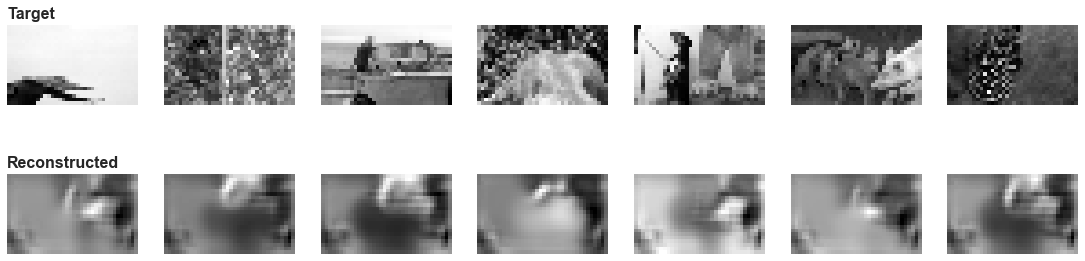

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/gan/2024-04-05_01-15-15/samples/stim_comparison_1e.png.
[2/100]


In [16]:
### train
decoder.train()
s, e = len(history["val_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch}/{e}]")

    ### train and val
    dls, neuron_coords = get_all_data(config=config)
    train_dataloader, val_dataloader = dls["mouse_v1"]["train"], dls["mouse_v1"]["val"]
    history = train(
        model=decoder,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        config=config,
        history=history,
        live_plot=live_plot,
        epoch=epoch,
        log_freq=log_freq,
    )
    val_losses = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
    )

    ### save best model
    if val_losses["total"] < best["val_loss"]:
        best["val_loss"] = val_losses["total"]
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["val_loss"].append(val_losses["total"])
    print(f"{val_losses['total']=:.4f}", end="")
    if config["wandb"]: wdb_run.log({"val_loss": val_losses["total"]}, commit=False)
    for data_key, loss in val_losses.items():
        if data_key != "total":
            print(f", {data_key}: {loss:.4f}", end="")
    print("")

    ### plot reconstructions
    stim_pred = decoder(
        resp[:8].to(config["device"]),
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_data_key],
        pupil_center=pupil_center[:8].to(config["device"]),
    ).detach()
    fig = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu(), save_to=make_sample_path(epoch, ""))
    if config["wandb"]: wdb_run.log({"val_stim_reconstruction": fig})

    ### plot losses
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch, save_to=os.path.join(config["dir"], f"losses_{epoch}.png") if config["decoder"]["save_run"] else None)

    ### save ckpt
    if epoch % 5 == 0 and epoch > 0:
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

In [ ]:
### final evaluation + logging + saving
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"), pickle_module=dill)

### eval on test set w/ current params
print("Evaluating on test set with current model...")
dls, neuron_coords = get_all_data(config=config)
test_loss_curr = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn,
)
print(f"  Test loss (current model): {test_loss_curr['total']:.4f}")
stim_pred_curr = decoder(
    resp.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
).detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_curr[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_latest_model.png") if config["decoder"]["save_run"] else None,
    pred_title="Reconstructed (latest model)"
)


### load best model
decoder.core.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "G" in k or "D" in k})
decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "readin" in k})

### eval on test set w/ best params
print("Evaluating on test set with best model...")
dls, neuron_coords = get_all_data(config=config)
test_loss_final = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn,
)
print(f"  Test loss (best model): {test_loss_final['total']:.4f}")

### plot reconstructions of the final model
stim_pred_best = decoder(
    resp.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
).detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

### log
if config["wandb"]:
    wandb.run.summary["best_val_loss"] = best["val_loss"]
    wandb.run.summary["best_epoch"] = best["epoch"]
    wandb.run.summary["curr_test_loss"] = test_loss_curr["total"]
    wandb.run.summary["final_test_loss"] = test_loss_final["total"]
    wandb.run.summary["best_reconstruction"] = fig

### save/delete wandb run
if config["wandb"]:
    if input("Delete run with 'd', save with anything else: ") == "d":
        print("Deleting wandb run...")
        api = wandb.Api()
        run = api.run(f"johnny1188/{config['wandb']['project']}/{wdb_run.id}")
        run.delete()
    else:
        wdb_run.finish()

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)

In [ ]:
live_plot.draw()

In [ ]:
stim_training, resp_training = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[0]))
stim_training_pred_best = decoder(resp_training.to(config["device"]), data_key=sample_data_key).detach().cpu()
plot_comparison(
    target=stim_training[:8].cpu(),
    pred=stim_training_pred_best[:8].cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)